In [6]:
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [7]:
db_path = '../data_to_sql/sql/eleicao.db' 
connection = sqlite3.connect(db_path)

In [8]:
cur = connection.cursor()

In [9]:
query = """
SELECT SUM(vp.QT_VOTOS_NOMINAIS_VALIDOS) as num_votos, p.NM_PARTIDO, p.SG_PARTIDO
FROM votos_partido as vp, partido as p, municipio as m
WHERE vp.DS_CARGO = 'DEPUTADO FEDERAL' AND vp.NR_PARTIDO = p.NR_PARTIDO AND vp.CD_MUN = m.cd_mun
GROUP BY p.SG_PARTIDO, p.NM_PARTIDO, p.SG_PARTIDO
ORDER BY SUM(vp.QT_VOTOS_NOMINAIS_VALIDOS) DESC
LIMIT 5
"""


top_5_partidos = pd.read_sql_query(query, connection)
top_5_partidos

,num_votos,NM_PARTIDO,SG_PARTIDO
0,2515014,PARTIDO DOS TRABALHADORES,PT
1,2170884,PARTIDO SOCIAL DEMOCRATICO,PSD
2,2092090,UNIAO BRASIL,UNIAO
3,1515206,PROGRESSISTAS,PP
4,1189762,PARTIDO LIBERAL,PL


In [10]:
query = """
SELECT m.GEOMETRY, m.nm_mun, QT_VOTOS_NOMINAIS_VALIDOS * 100.0 / v0001 as num_votos, p.SG_PARTIDO as sigla_partido
FROM votos_partido as vp, municipio as m, basico as b, partido as p
WHERE vp.DS_CARGO = 'DEPUTADO FEDERAL' AND vp.CD_MUN = m.cd_mun AND vp.CD_MUN = b.CD_MUN AND vp.NR_PARTIDO = p.NR_PARTIDO AND p.SG_PARTIDO IN ('PT', 'PSD', 'UNIAO', 'PP', 'PL')
GROUP BY nm_mun, SG_PARTIDO
ORDER BY nm_mun
"""

dados = gpd.read_postgis(query, connection, geom_col="GEOMETRY")

In [11]:
# Verificar o sistema de coordenadas
dados.crs = 'EPSG:4674'

# Verificar as primeiras linhas
print(dados.head())
 
# Pivotar os dados para que cada partido seja uma coluna
dados_pivot = dados.pivot(index=['nm_mun', 'GEOMETRY'], columns='sigla_partido', values='num_votos').reset_index()

# Substituir valores NaN por 0
dados_pivot.fillna(0, inplace=True)

# Salvar a geometria
dados_pivot = gpd.GeoDataFrame(dados_pivot, geometry='GEOMETRY')

                                            GEOMETRY nm_mun  num_votos  \
0  POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...  Abaré   0.413856   
1  POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...  Abaré  13.135665   
2  POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...  Abaré   2.352741   
3  POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...  Abaré  25.330234   
4  POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...  Abaré  13.674245   

  sigla_partido  
0            PL  
1            PP  
2           PSD  
3            PT  
4         UNIAO  


In [12]:
dados_pivot

sigla_partido,nm_mun,GEOMETRY,PL,PP,PSD,PT,UNIAO
0,Abaré,"POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...",0.413856,13.135665,2.352741,25.330234,13.674245
1,Abaíra,"POLYGON ((-41.74667 -13.32509, -41.74679 -13.3...",1.328585,0.808108,15.271881,3.273524,30.639638
2,Acajutiba,"POLYGON ((-38.02809 -11.75007, -38.02811 -11.7...",1.667271,12.381298,26.038420,3.204059,1.522291
3,Adustina,"POLYGON ((-37.97867 -10.652, -37.97874 -10.652...",3.591296,0.633758,29.343004,8.612070,0.922470
4,Aiquara,"POLYGON ((-39.83121 -14.08248, -39.83118 -14.0...",1.259276,1.709017,18.731729,12.592759,23.836294
...,...,...,...,...,...,...,...
412,Wanderley,"POLYGON ((-43.82392 -12.12517, -43.82324 -12.1...",1.326342,0.462677,1.472856,4.256632,32.225478
413,Wenceslau Guimarães,"POLYGON ((-39.49336 -13.60308, -39.49335 -13.6...",0.645583,4.944022,1.993953,7.669363,21.234780
414,Xique-Xique,"POLYGON ((-42.52305 -10.90382, -42.52306 -10.9...",1.499207,2.781688,8.749469,12.684049,15.671292
415,Água Fria,"POLYGON ((-38.60169 -11.92432, -38.59707 -11.9...",1.069187,1.289922,4.925157,10.678071,4.863075


In [13]:
!pip install pysal

Defaulting to user installation because normal site-packages is not writeable


In [14]:
from pysal.lib import weights
from pysal.explore import esda

# Criar matriz de vizinhança (Queen)
w = weights.Queen.from_dataframe(dados_pivot)

# Normalizar os pesos
w.transform = 'R'

for partido in ['PT', 'PSD', 'UNIAO', 'PP', 'PL']:
    y = dados_pivot[partido]  # Substitua pelo nome da coluna do partido
    moran = esda.Moran(y, w)
    print(f'Partido: {partido}, Índice de Moran: {moran.I}, p-valor: {moran.p_sim}')

/home/gfjallais/.local/lib/python3.10/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/home/gfjallais/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_35625/816853399.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and sil

Partido: PT, Índice de Moran: 0.15429847286249038, p-valor: 0.001
Partido: PSD, Índice de Moran: 0.24343464977611318, p-valor: 0.001
Partido: UNIAO, Índice de Moran: 0.3119451559868644, p-valor: 0.001
Partido: PP, Índice de Moran: 0.061197170903482506, p-valor: 0.031
Partido: PL, Índice de Moran: 0.1476846512398487, p-valor: 0.001


In [15]:
for partido in ['PT', 'PSD', 'UNIAO', 'PP', 'PL']:
    y = dados_pivot[partido]  # Escolha o partido
    lisa = esda.Moran_Local(y, w)

    # Adicionar resultados ao GeoDataFrame
    dados_pivot[f"LISA_cluster_{partido}"] = lisa.q  # Cluster (1, 2, 3, 4 para Alto-Alto, Baixo-Baixo, etc.)
    dados_pivot[f"LISA_pvalor_{partido}"] = lisa.p_sim  # P-valor local

In [16]:
dados_pivot

sigla_partido,nm_mun,GEOMETRY,PL,PP,PSD,PT,UNIAO,LISA_cluster_PT,LISA_pvalor_PT,LISA_cluster_PSD,LISA_pvalor_PSD,LISA_cluster_UNIAO,LISA_pvalor_UNIAO,LISA_cluster_PP,LISA_pvalor_PP,LISA_cluster_PL,LISA_pvalor_PL
0,Abaré,"POLYGON ((-39.23481 -8.70419, -39.23427 -8.705...",0.413856,13.135665,2.352741,25.330234,13.674245,4,0.339,3,0.408,4,0.235,1,0.047,3,0.057
1,Abaíra,"POLYGON ((-41.74667 -13.32509, -41.74679 -13.3...",1.328585,0.808108,15.271881,3.273524,30.639638,3,0.063,1,0.311,1,0.045,2,0.008,3,0.273
2,Acajutiba,"POLYGON ((-38.02809 -11.75007, -38.02811 -11.7...",1.667271,12.381298,26.038420,3.204059,1.522291,3,0.410,4,0.215,3,0.228,1,0.201,3,0.481
3,Adustina,"POLYGON ((-37.97867 -10.652, -37.97874 -10.652...",3.591296,0.633758,29.343004,8.612070,0.922470,3,0.006,4,0.386,3,0.005,3,0.476,1,0.009
4,Aiquara,"POLYGON ((-39.83121 -14.08248, -39.83118 -14.0...",1.259276,1.709017,18.731729,12.592759,23.836294,4,0.132,4,0.153,1,0.245,3,0.459,3,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,Wanderley,"POLYGON ((-43.82392 -12.12517, -43.82324 -12.1...",1.326342,0.462677,1.472856,4.256632,32.225478,3,0.497,3,0.047,1,0.004,2,0.336,3,0.471
413,Wenceslau Guimarães,"POLYGON ((-39.49336 -13.60308, -39.49335 -13.6...",0.645583,4.944022,1.993953,7.669363,21.234780,3,0.004,3,0.286,1,0.133,2,0.003,3,0.014
414,Xique-Xique,"POLYGON ((-42.52305 -10.90382, -42.52306 -10.9...",1.499207,2.781688,8.749469,12.684049,15.671292,1,0.114,3,0.429,4,0.109,3,0.473,2,0.038
415,Água Fria,"POLYGON ((-38.60169 -11.92432, -38.59707 -11.9...",1.069187,1.289922,4.925157,10.678071,4.863075,1,0.061,2,0.161,3,0.367,3,0.162,3,0.032


In [17]:
pip install contextily

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm  # Import BoundaryNorm

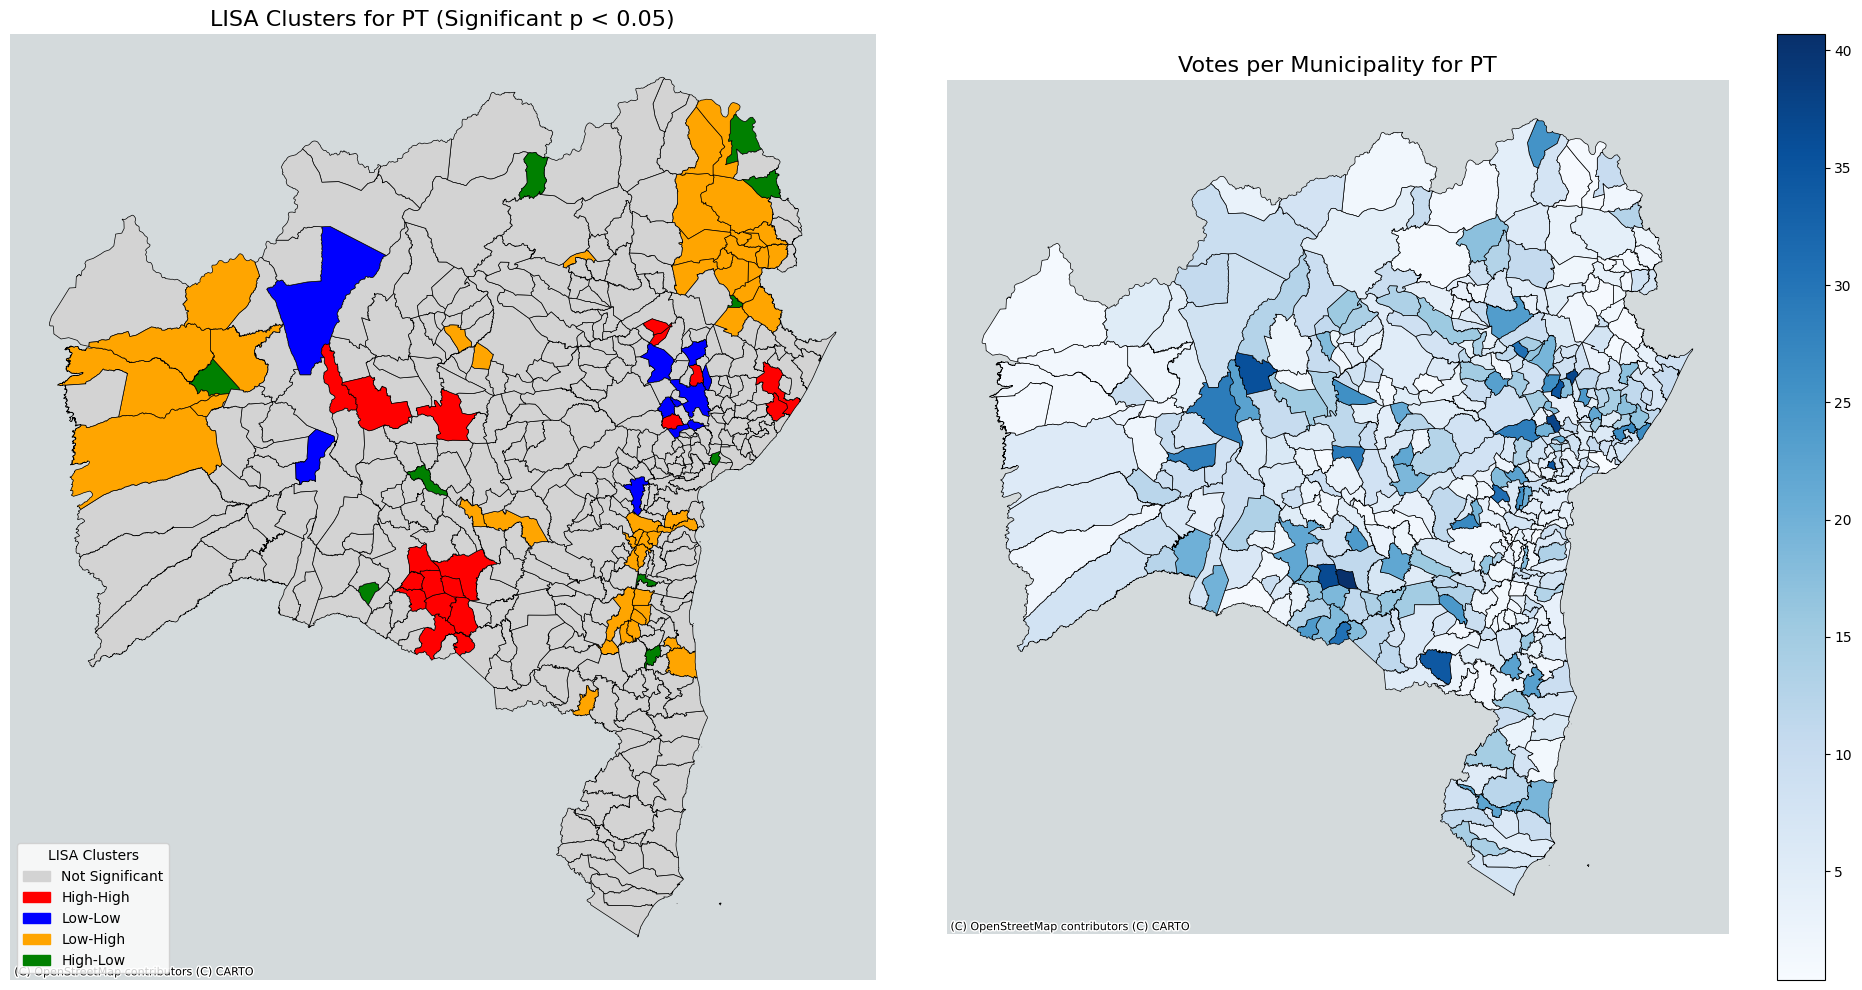

In [19]:
# Load your GeoDataFrame
gdf = dados_pivot  # Assuming `dados_pivot` is your GeoDataFrame

# Choose the party to visualize
party = 'PT'
cluster_col = f'LISA_cluster_{party}'  # Column for LISA clusters
pval_col = f'LISA_pvalor_{party}'      # Column for LISA p-values

# Define significance level
significance_level = 0.05

# Filter significant clusters
gdf['Significant'] = gdf[pval_col] < significance_level

# Map cluster values (only significant ones)
gdf['Cluster_Display'] = gdf[cluster_col].where(gdf['Significant'], 0)

# Define colors and labels for LISA clusters
colors = ['lightgray', 'red', 'blue', 'orange', 'green']  # Default colors
labels = ['Not Significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low']
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(6), cmap.N)  # Define boundaries for clusters

# Create the subplot for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: LISA Clusters
ax1 = axes[0]
gdf.plot(column='Cluster_Display', cmap=cmap, linewidth=0.5, edgecolor='black', ax=ax1, norm=norm)

# Add basemap for context to the LISA map
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=7)

# Add custom legend for LISA Clusters
legend_patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]
ax1.legend(handles=legend_patches, loc='lower left', title="LISA Clusters")

# Title and cleanup for LISA map
ax1.set_title(f"LISA Clusters for {party} (Significant p < {significance_level})", fontsize=16)
ax1.axis('off')

# Plot 2: Votes per Municipality (Total votes per municipality)
# Choose the column for the number of votes or proportion of votes
vote_col = 'PT'  # Replace with the appropriate column, e.g., total votes or proportion

# You may need to calculate the 'proporcao_votos_PT' first if not already done
# gdf['proporcao_votos_PT'] = gdf['PT'] / gdf['populacao']

# Plot the number of votes or proportion of votes
ax2 = axes[1]
gdf.plot(column=vote_col, cmap='Blues', linewidth=0.5, edgecolor='black', ax=ax2, legend=True)

# Add basemap for context to the second map
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=7)

# Title and cleanup for the votes map
ax2.set_title(f"Votes per Municipality for {party}", fontsize=16)
ax2.axis('off')

# Show the plot with both subplots
plt.tight_layout()
plt.show()


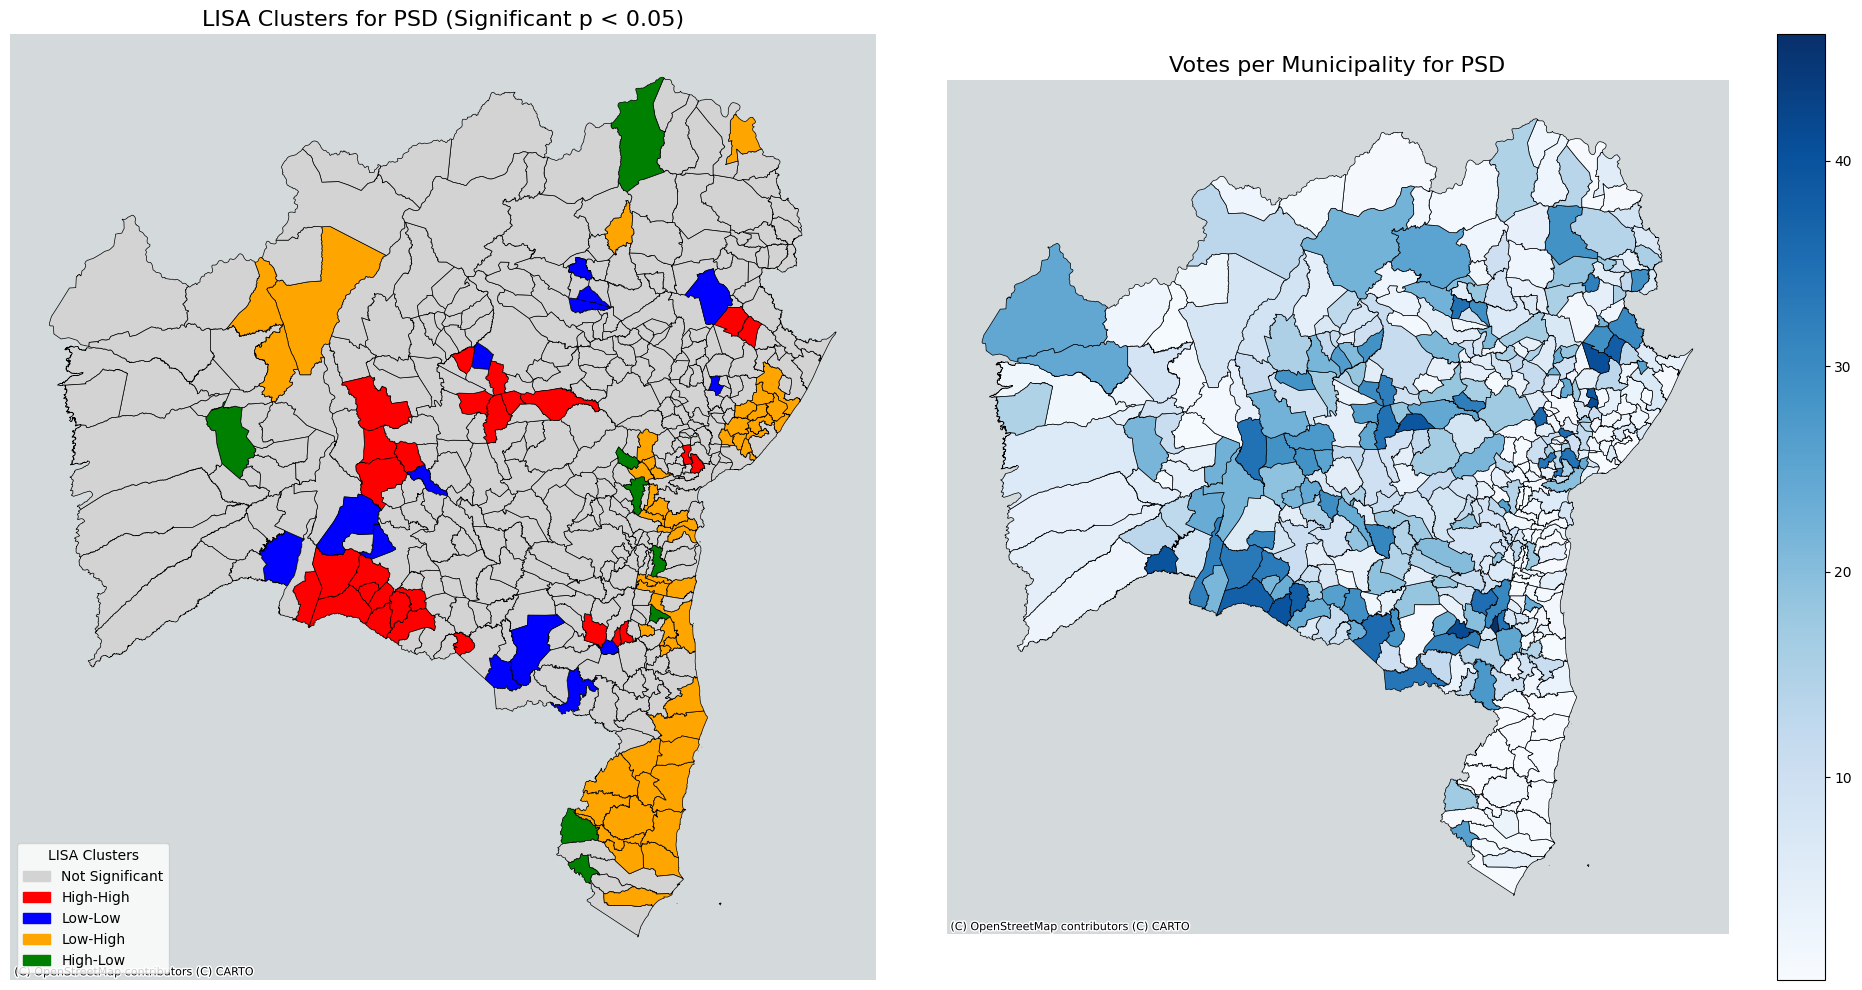

In [20]:
# Choose the party to visualize
party = 'PSD'
cluster_col = f'LISA_cluster_{party}'  # Column for LISA clusters
pval_col = f'LISA_pvalor_{party}'      # Column for LISA p-values

# Define significance level
significance_level = 0.05

# Filter significant clusters
gdf['Significant'] = gdf[pval_col] < significance_level

# Map cluster values (only significant ones)
gdf['Cluster_Display'] = gdf[cluster_col].where(gdf['Significant'], 0)

# Define colors and labels for LISA clusters
colors = ['lightgray', 'red', 'blue', 'orange', 'green']  # Default colors
labels = ['Not Significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low']
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(6), cmap.N)  # Define boundaries for clusters

# Create the subplot for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: LISA Clusters
ax1 = axes[0]
gdf.plot(column='Cluster_Display', cmap=cmap, linewidth=0.5, edgecolor='black', ax=ax1, norm=norm)

# Add basemap for context to the LISA map
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=7)

# Add custom legend for LISA Clusters
legend_patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]
ax1.legend(handles=legend_patches, loc='lower left', title="LISA Clusters")

# Title and cleanup for LISA map
ax1.set_title(f"LISA Clusters for {party} (Significant p < {significance_level})", fontsize=16)
ax1.axis('off')

# Plot 2: Votes per Municipality (Total votes per municipality)
# Choose the column for the number of votes or proportion of votes
vote_col = 'PSD'  # Replace with the appropriate column, e.g., total votes or proportion

# You may need to calculate the 'proporcao_votos_PT' first if not already done
# gdf['proporcao_votos_PT'] = gdf['PT'] / gdf['populacao']

# Plot the number of votes or proportion of votes
ax2 = axes[1]
gdf.plot(column=vote_col, cmap='Blues', linewidth=0.5, edgecolor='black', ax=ax2, legend=True)

# Add basemap for context to the second map
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=7)

# Title and cleanup for the votes map
ax2.set_title(f"Votes per Municipality for {party}", fontsize=16)
ax2.axis('off')

# Show the plot with both subplots
plt.tight_layout()
plt.show()

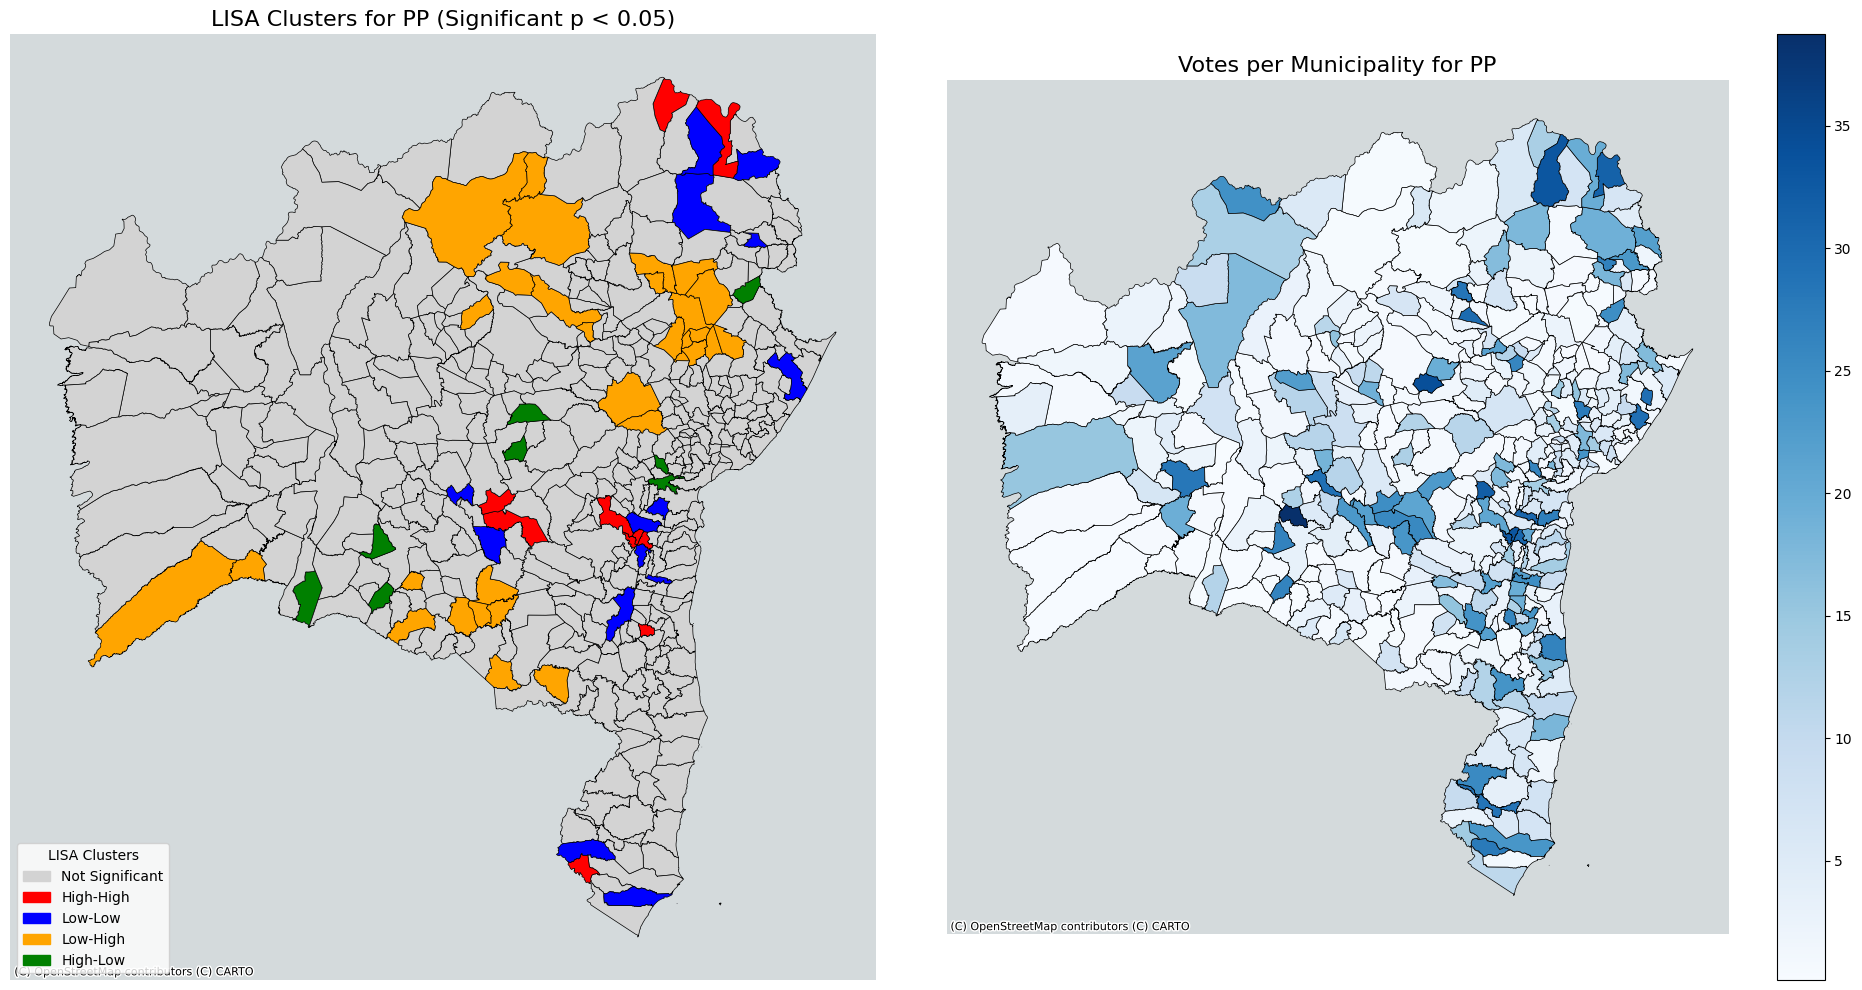

In [21]:
# Choose the party to visualize
party = 'PP'
cluster_col = f'LISA_cluster_{party}'  # Column for LISA clusters
pval_col = f'LISA_pvalor_{party}'      # Column for LISA p-values

# Define significance level
significance_level = 0.05

# Filter significant clusters
gdf['Significant'] = gdf[pval_col] < significance_level

# Map cluster values (only significant ones)
gdf['Cluster_Display'] = gdf[cluster_col].where(gdf['Significant'], 0)

# Define colors and labels for LISA clusters
colors = ['lightgray', 'red', 'blue', 'orange', 'green']  # Default colors
labels = ['Not Significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low']
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(6), cmap.N)  # Define boundaries for clusters

# Create the subplot for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: LISA Clusters
ax1 = axes[0]
gdf.plot(column='Cluster_Display', cmap=cmap, linewidth=0.5, edgecolor='black', ax=ax1, norm=norm)

# Add basemap for context to the LISA map
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=7)

# Add custom legend for LISA Clusters
legend_patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]
ax1.legend(handles=legend_patches, loc='lower left', title="LISA Clusters")

# Title and cleanup for LISA map
ax1.set_title(f"LISA Clusters for {party} (Significant p < {significance_level})", fontsize=16)
ax1.axis('off')

# Plot 2: Votes per Municipality (Total votes per municipality)
# Choose the column for the number of votes or proportion of votes
vote_col = 'PP'  # Replace with the appropriate column, e.g., total votes or proportion

# You may need to calculate the 'proporcao_votos_PT' first if not already done
# gdf['proporcao_votos_PT'] = gdf['PT'] / gdf['populacao']

# Plot the number of votes or proportion of votes
ax2 = axes[1]
gdf.plot(column=vote_col, cmap='Blues', linewidth=0.5, edgecolor='black', ax=ax2, legend=True)

# Add basemap for context to the second map
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=7)

# Title and cleanup for the votes map
ax2.set_title(f"Votes per Municipality for {party}", fontsize=16)
ax2.axis('off')

# Show the plot with both subplots
plt.tight_layout()
plt.show()

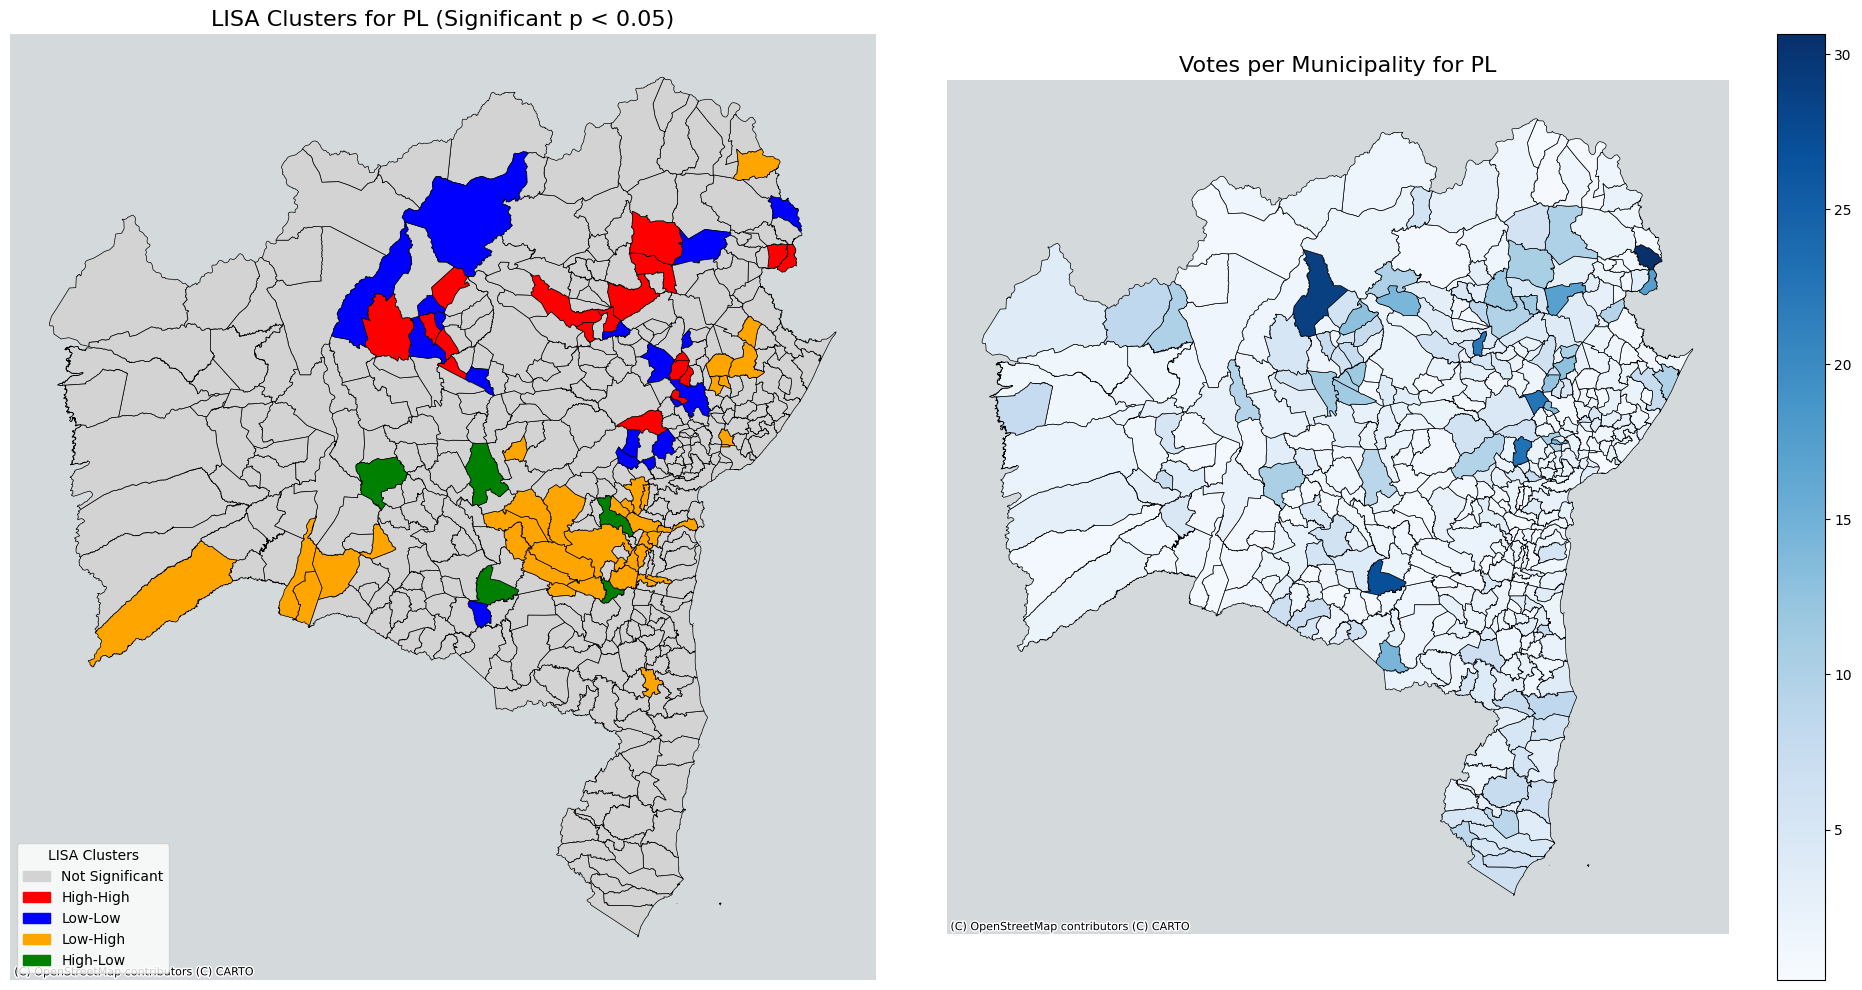

In [22]:
party = 'PL'
cluster_col = f'LISA_cluster_{party}'  # Column for LISA clusters
pval_col = f'LISA_pvalor_{party}'      # Column for LISA p-values

# Define significance level
significance_level = 0.05

# Filter significant clusters
gdf['Significant'] = gdf[pval_col] < significance_level

# Map cluster values (only significant ones)
gdf['Cluster_Display'] = gdf[cluster_col].where(gdf['Significant'], 0)

# Define colors and labels for LISA clusters
colors = ['lightgray', 'red', 'blue', 'orange', 'green']  # Default colors
labels = ['Not Significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low']
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(6), cmap.N)  # Define boundaries for clusters

# Create the subplot for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: LISA Clusters
ax1 = axes[0]
gdf.plot(column='Cluster_Display', cmap=cmap, linewidth=0.5, edgecolor='black', ax=ax1, norm=norm)

# Add basemap for context to the LISA map
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=7)

# Add custom legend for LISA Clusters
legend_patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]
ax1.legend(handles=legend_patches, loc='lower left', title="LISA Clusters")

# Title and cleanup for LISA map
ax1.set_title(f"LISA Clusters for {party} (Significant p < {significance_level})", fontsize=16)
ax1.axis('off')

# Plot 2: Votes per Municipality (Total votes per municipality)
# Choose the column for the number of votes or proportion of votes
vote_col = 'PL'  # Replace with the appropriate column, e.g., total votes or proportion

# You may need to calculate the 'proporcao_votos_PT' first if not already done
# gdf['proporcao_votos_PT'] = gdf['PT'] / gdf['populacao']

# Plot the number of votes or proportion of votes
ax2 = axes[1]
gdf.plot(column=vote_col, cmap='Blues', linewidth=0.5, edgecolor='black', ax=ax2, legend=True)

# Add basemap for context to the second map
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=7)

# Title and cleanup for the votes map
ax2.set_title(f"Votes per Municipality for {party}", fontsize=16)
ax2.axis('off')

# Show the plot with both subplots
plt.tight_layout()
plt.show()

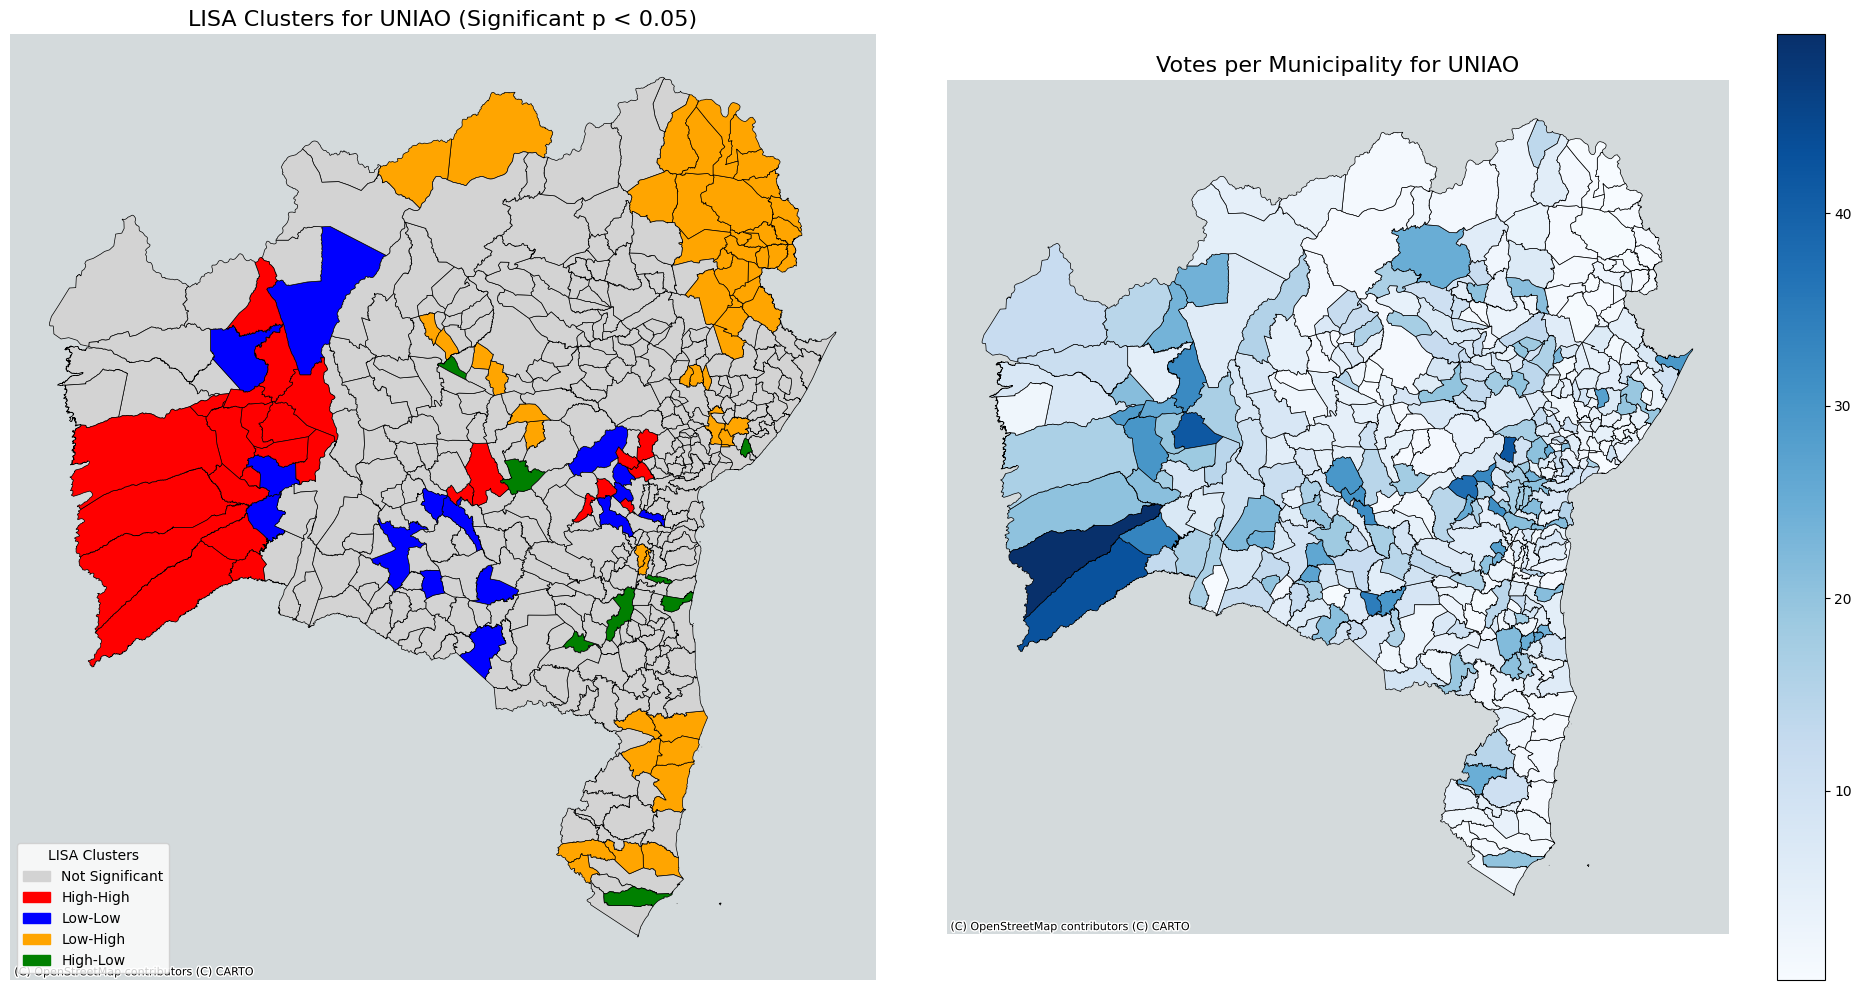

In [23]:
party = 'UNIAO'
cluster_col = f'LISA_cluster_{party}'  # Column for LISA clusters
pval_col = f'LISA_pvalor_{party}'      # Column for LISA p-values

# Define significance level
significance_level = 0.05

# Filter significant clusters
gdf['Significant'] = gdf[pval_col] < significance_level

# Map cluster values (only significant ones)
gdf['Cluster_Display'] = gdf[cluster_col].where(gdf['Significant'], 0)

# Define colors and labels for LISA clusters
colors = ['lightgray', 'red', 'blue', 'orange', 'green']  # Default colors
labels = ['Not Significant', 'High-High', 'Low-Low', 'Low-High', 'High-Low']
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(6), cmap.N)  # Define boundaries for clusters

# Create the subplot for side-by-side plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: LISA Clusters
ax1 = axes[0]
gdf.plot(column='Cluster_Display', cmap=cmap, linewidth=0.5, edgecolor='black', ax=ax1, norm=norm)

# Add basemap for context to the LISA map
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, zoom=7)

# Add custom legend for LISA Clusters
legend_patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]
ax1.legend(handles=legend_patches, loc='lower left', title="LISA Clusters")

# Title and cleanup for LISA map
ax1.set_title(f"LISA Clusters for {party} (Significant p < {significance_level})", fontsize=16)
ax1.axis('off')

# Plot 2: Votes per Municipality (Total votes per municipality)
# Choose the column for the number of votes or proportion of votes
vote_col = 'UNIAO'  # Replace with the appropriate column, e.g., total votes or proportion

# You may need to calculate the 'proporcao_votos_PT' first if not already done
# gdf['proporcao_votos_PT'] = gdf['PT'] / gdf['populacao']

# Plot the number of votes or proportion of votes
ax2 = axes[1]
gdf.plot(column=vote_col, cmap='Blues', linewidth=0.5, edgecolor='black', ax=ax2, legend=True)

# Add basemap for context to the second map
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron, zoom=7)

# Title and cleanup for the votes map
ax2.set_title(f"Votes per Municipality for {party}", fontsize=16)
ax2.axis('off')

# Show the plot with both subplots
plt.tight_layout()
plt.show()